Loading and Plotting surface EMG Data
=====================================

Here we show how to load and visualize EMG data collected at the wrist as described in the paper ["A generic noninvasive neuromotor interface for human-computer interaction"](https://www.biorxiv.org/content/10.1101/2024.02.23.581779v1.full.pdf). We will show examples from each of the three tasks described in the paper: `discrete_gestures`, `handwriting`, and `wrist`.

# Setup

First download the data, as described in the `README`. If necessary, set the `root_data_folder` below to the location of the files.

In [1]:
%load_ext autoreload
%autoreload 2


from generic_neuromotor_interface.explore_data.plot import plot_emg, plot_wrist
from generic_neuromotor_interface.explore_data.load import load_data
from generic_neuromotor_interface.constants import Task
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import glob
import os


DATA_FOLDER = "~/emg_data/"

def get_task_dataset_paths(task: Task):
    """Get full paths to all datasets for a given task."""
    folder = os.path.expanduser(DATA_FOLDER)
    datasets = glob.glob(os.path.join(folder, '*.hdf5'))
    return [d for d in datasets if task in d]

# Loading data

Next we'll select one of the `discrete_gesture` files.

In [2]:
file = get_task_dataset_paths("discrete_gestures")[0]
print("Selected file:", os.path.basename(file))

Selected file: discrete_gestures_user_002_dataset_000.hdf5


We'll load the file using the `load_data` utility function.

In [3]:
data = load_data(file)
data

The file contains EMG, timestamps, a task identifier, a `prompts` dataframe with the timing of all the gestures, and a `stages` dataframe with the timing of the different experimental stages.

In [4]:
print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("stages:")
display(data.stages.head())
print("prompts:")
display(data.prompts)

task:             discrete_gestures
emg shape:        (3982280, 16)
timestamp shape:  (3982280,)
stages:


,start,end,name
0,1.644503e+09,1.644503e+09,pinch_practice
1,1.644503e+09,1.644503e+09,pinch_release_static_hand_in_lap_with_taps
2,1.644503e+09,1.644503e+09,thumb_swipes_practice
3,1.644503e+09,1.644503e+09,thumb_swipes_static_arm_in_lap
4,1.644503e+09,1.644503e+09,thumb_swipes_static_arm_front


prompts:


,name,time
0,middle_press,1.644503e+09
1,middle_release,1.644503e+09
2,middle_press,1.644503e+09
3,middle_release,1.644503e+09
4,middle_press,1.644503e+09
...,...,...
1168,thumb_down,1.644504e+09
1169,thumb_in,1.644504e+09
1170,thumb_in,1.644504e+09
1171,thumb_up,1.644504e+09


Data are similarly structured for the `handwriting` datasets. However, the dataframe now encodes the start and end times of each text prompt. Right and left arrows correspond to finger movements to the right and left that are used as spaces and backspaces, respectively (see paper for details). The hand emoji indicates a finger pinch.

In [5]:
file = get_task_dataset_paths("handwriting")[0]
data = load_data(file)

print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("stages:")
display(data.stages.head())
print("prompts:")
display(data.prompts)

task:             handwriting
emg shape:        (1797000, 16)
timestamp shape:  (1797000,)
stages:


,start,end,name,posture
0,1.676299e+09,1.676299e+09,characters_with_digits,standing-on-leg
1,1.676299e+09,1.676299e+09,words,standing-on-leg
2,1.676299e+09,1.676299e+09,words_with_backspace,standing-on-leg
3,1.676299e+09,1.676299e+09,words,standing-on-leg
4,1.676299e+09,1.676299e+09,two_digit_numbers,standing-on-leg


prompts:


,prompt,start,end
0,y,1.676299e+09,1.676299e+09
1,←,1.676299e+09,1.676299e+09
2,d,1.676299e+09,1.676299e+09
3,e,1.676299e+09,1.676299e+09
4,4,1.676299e+09,1.676299e+09
...,...,...,...
89,silver is one of🤏,1.676300e+09,1.676300e+09
90,the only words in🤏,1.676300e+09,1.676300e+09
91,g←the underside of the🤏,1.676300e+09,1.676300e+09
92,some→ people→ were→ his🤏,1.676300e+09,1.676300e+09


The `wrist` datasets do not have a `prompts` dataframe. Instead, they have an additional stream of `wrist_angles` data.

In [6]:
file = get_task_dataset_paths("wrist")[0]
data = load_data(file)

print("task:               ", data.task)
print("emg shape:          ", data.emg.shape)
print("wrist_angles shape: ", data.wrist_angles.shape)
print("timestamp shape:    ", data.time.shape)
print("stages:")
display(data.stages.head())

task:                wrist
emg shape:           (3654480, 16)
wrist_angles shape:  (3654480, 2)
timestamp shape:     (3654480,)
stages:


,start,end,name
0,1.714744e+09,1.714744e+09,open_loop_task
1,1.714744e+09,1.714744e+09,hold_neutral_wrist_angle
2,1.714744e+09,1.714744e+09,clockwise_wrist_circles
3,1.714744e+09,1.714744e+09,counterclockwise_wrist_circles
4,1.714744e+09,1.714744e+09,flexions_and_extensions


# Plotting data

## Discrete Gestures

Here we plot EMG snippets for a single `discrete_gesture` dataset in 1 second windows centered on different gesture types.

Notice the use of `gesture_data.partition(start_time, end_time)` to extract windows of EMG around events of interest.

In [7]:
gesture_file = get_task_dataset_paths("discrete_gestures")[0]
gesture_data = load_data(gesture_file)

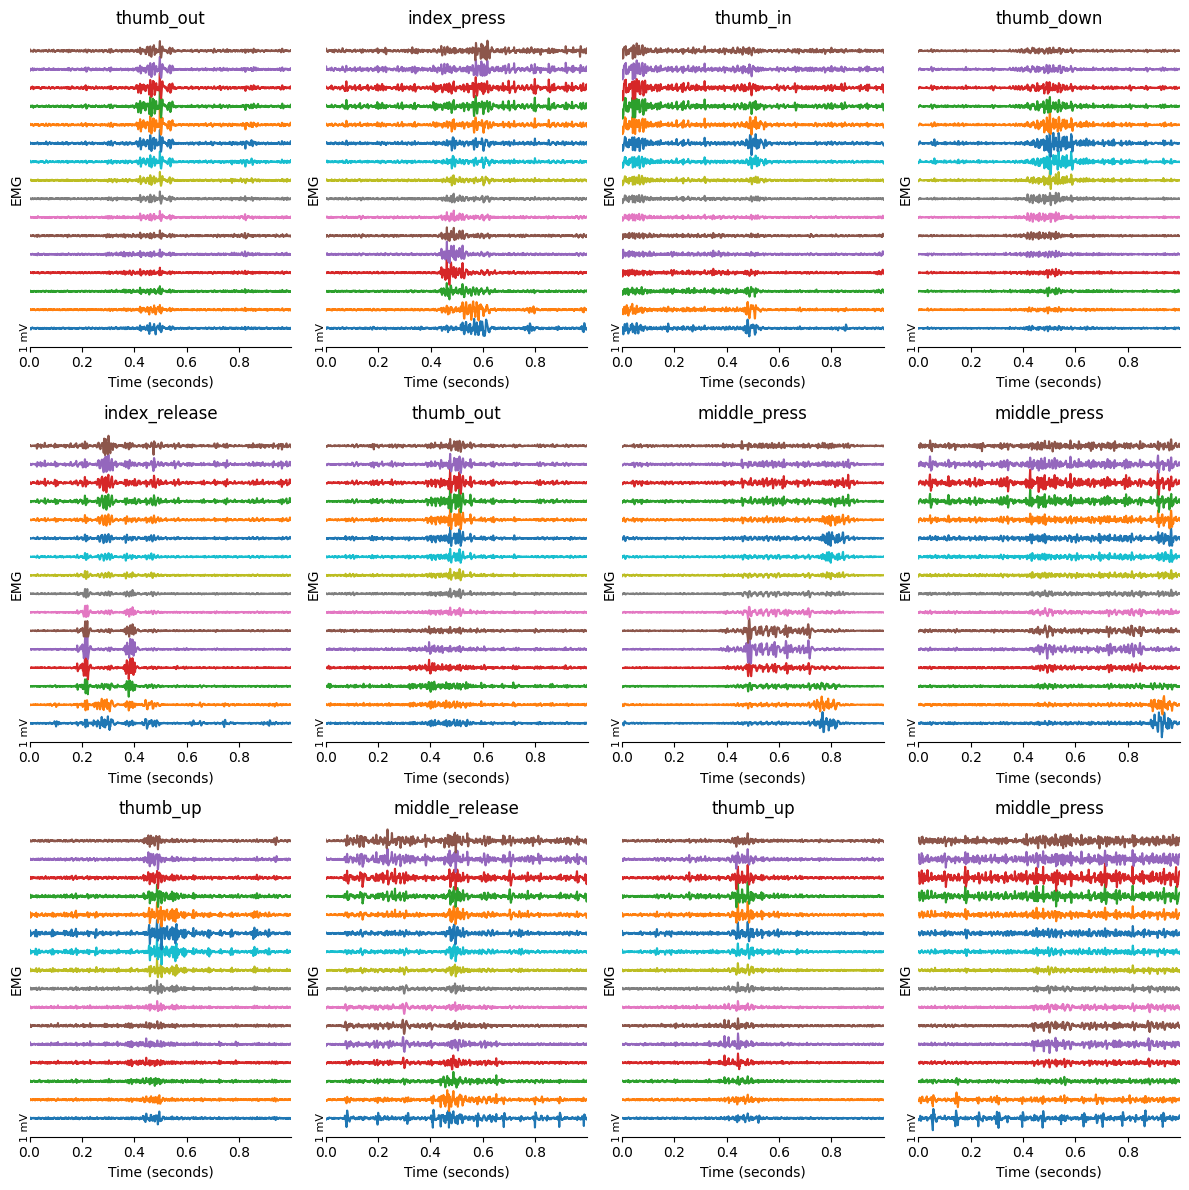

In [8]:
window = [-.5, .5]
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random gestures
gestures = gesture_data.prompts.sample(nrows * ncols, random_state=2, replace=False)

for ax, (_, gesture) in zip(axs.flatten(), gestures.iterrows()):
    timeseries = gesture_data.partition(gesture.time + window[0], gesture.time + window[1])
    plot_emg(timeseries["time"], timeseries["emg"], ax=ax)
    gesture_name = gesture.loc["name"]
    ax.set(title=f"{gesture_name}")

plt.tight_layout()

## Handwriting

Now we plot snippets of `handwriting` EMG corresponding to individual text prompts. Each snippet begins when the prompt first appears, and ends when the participant finishes writing the prompt.

In [9]:
handwriting_file = get_task_dataset_paths("handwriting")[1]
handwriting_data = load_data(handwriting_file)

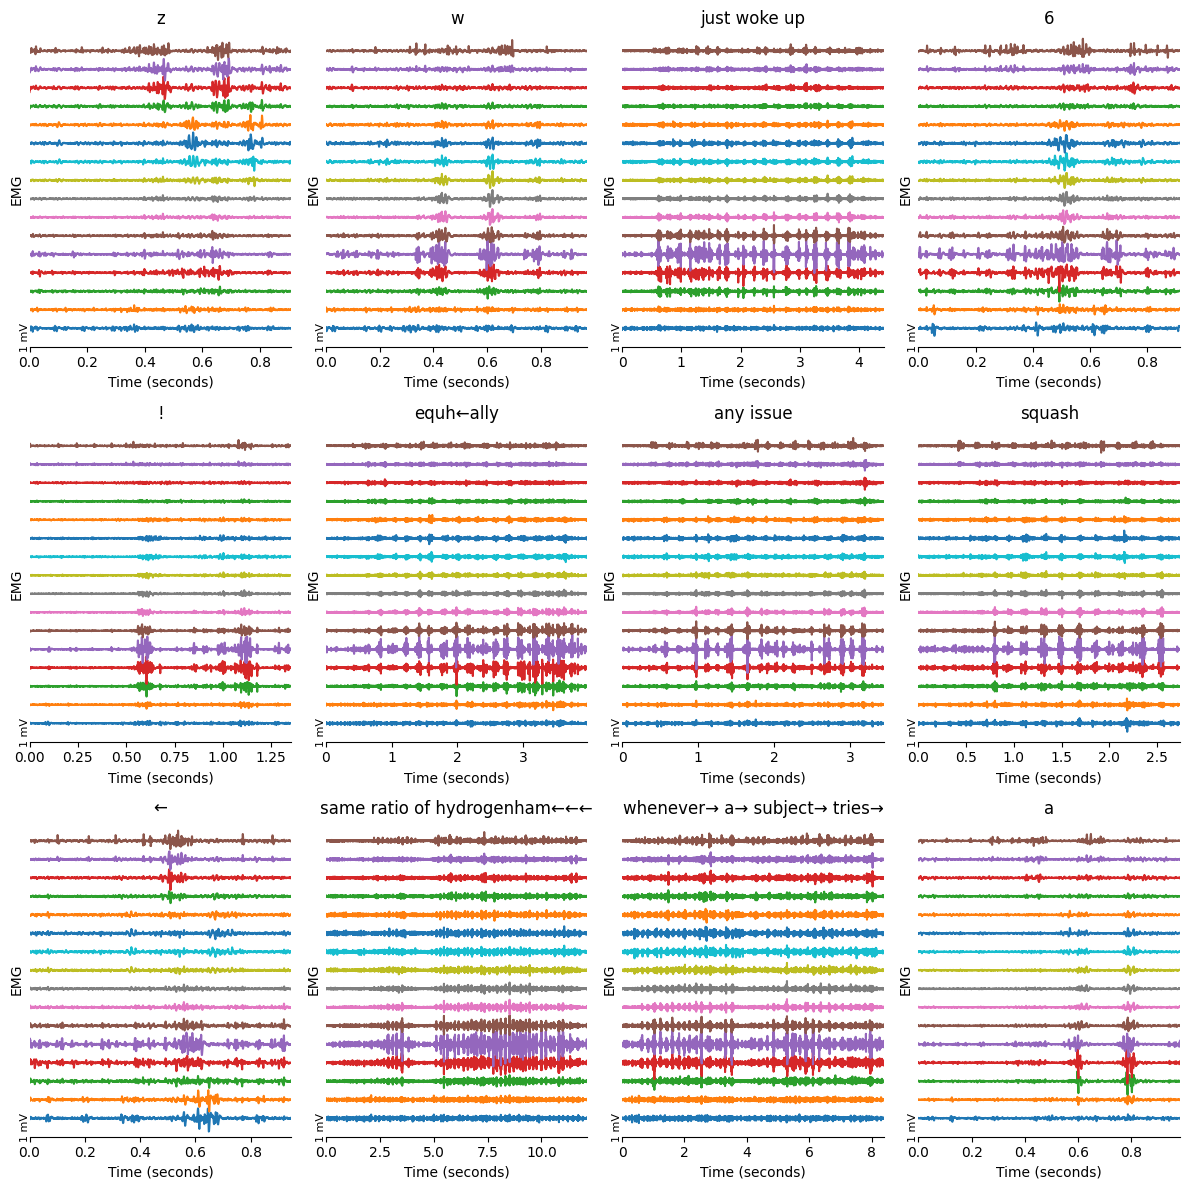

In [10]:
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random prompts
prompts = handwriting_data.prompts.sample(nrows * ncols, random_state=0, replace=False)

for ax, (_, prompt) in zip(axs.flatten(), prompts.iterrows()):
    timeseries = handwriting_data.partition(prompt.start, prompt.end)
    plot_emg(timeseries["time"], timeseries["emg"], ax=ax)
    ax.set(title=f"{prompt.prompt}")

plt.tight_layout()

## Wrist angles

Finally, we'll plot EMG and wrist angles side-by-side for a few example stages from a `wrist` dataset.

In [11]:
wrist_file = get_task_dataset_paths("wrist")[0]
wrist_data = load_data(wrist_file)

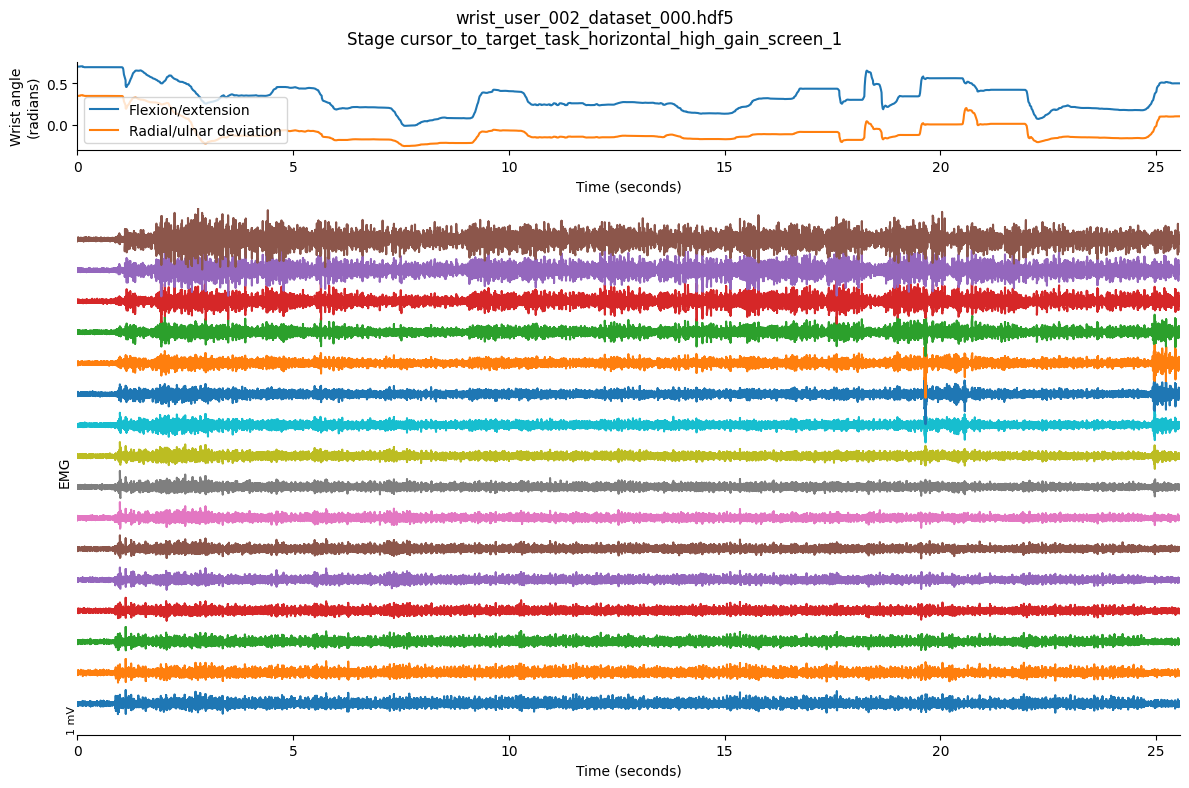

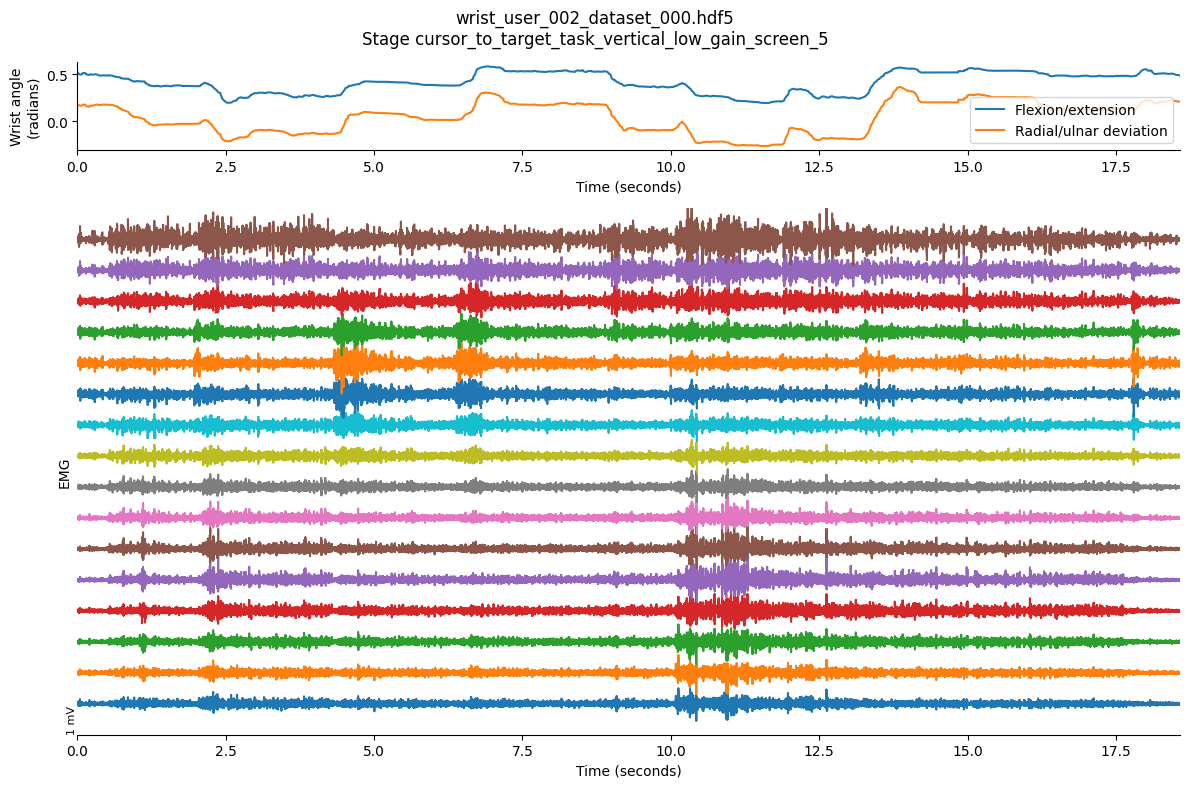

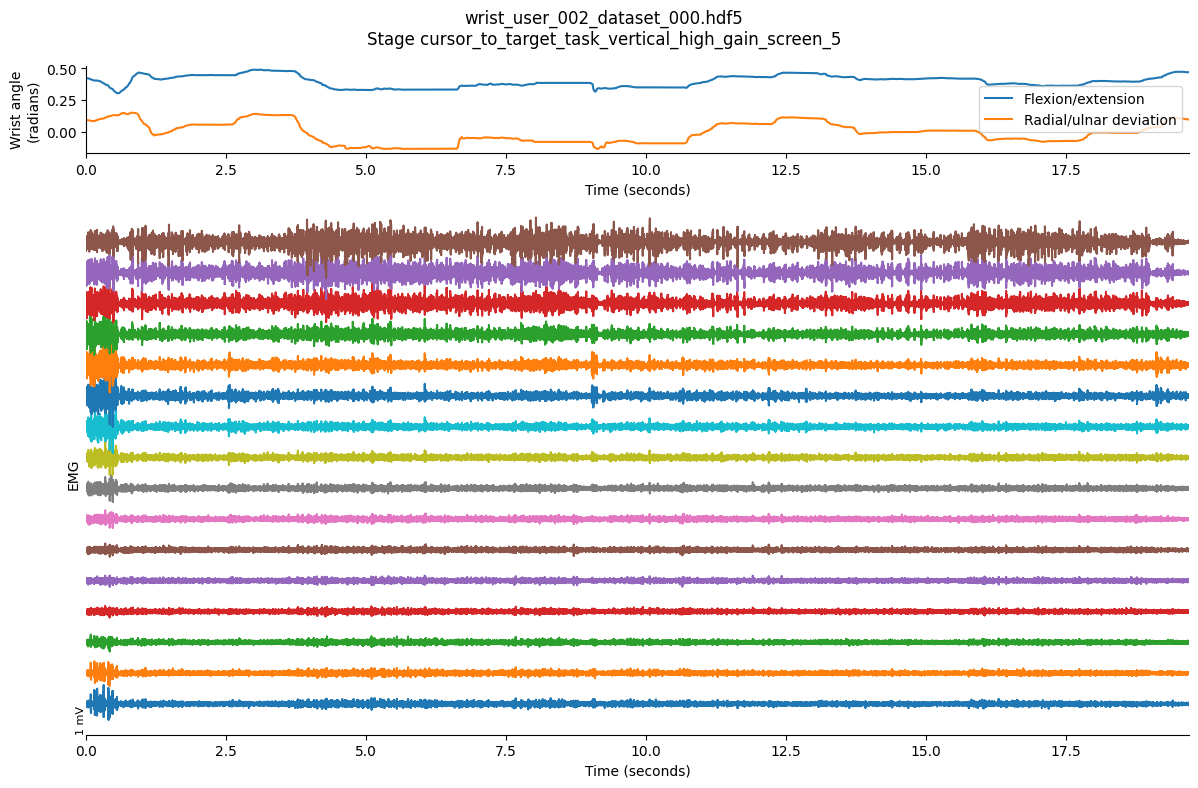

In [12]:
num_stages = 3

# Sample random stages
stages = wrist_data.stages.sample(num_stages, random_state=0, replace=False)

for _, stage in stages.iterrows():
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [1, 6]})
    timeseries = wrist_data.partition(stage.start, stage.end)
    
    plot_wrist(timeseries["time"], timeseries["wrist_angles"], ax=axs[0])
    plot_emg(timeseries["time"], timeseries["emg"], ax=axs[1])

    fig.suptitle(f"{os.path.basename(wrist_file)}\nStage {stage['name']}")
    plt.tight_layout()